In [73]:
import numpy as np
import pandas as pd
import preprocessing as pp
import tensorflow as tf
import preprocessing as pp
import matplotlib.pyplot as plt
import confusion_matrix as cmat
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [37]:
np.random.seed(1313)
tf.random.set_seed(1313)

In [ ]:
X, y, X_columns, y_columns = pp.load_data(suffix='_goal_difference_full_features')

In [ ]:
X, y, X_columns, y_columns = pp.preprocess(include=['danger', 'zones'], return_arrays=True, save_as_file=True, y_goal_diff=True, 
                                            suffix='_goal_difference_full_features')

In [3]:
classes = list(map(str, list(y_columns.keys())))

In [4]:
print(X.shape)
print(y.shape)

print(list(X_columns.keys()))
print(list(y_columns.keys()))

(11244, 366, 17)
(11244, 7)
['game_id', 'event_blocked_shot', 'event_faceoff', 'event_giveaway', 'event_hit', 'event_missed_shot', 'event_penalty', 'event_shot', 'event_takeaway', 'danger_a_high', 'danger_b_med', 'danger_c_low', 'danger_d_not_a_shot', 'event_dummy', 'home_team_for', 'offensive_zone_home', 'offensive_zone_away']
['-3', '-2', '-1', '0', '1', '2', '3']


In [142]:
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X[:,:,1:], y, X[:, 0, 0], test_size=0.25)

In [ ]:
# data = {'Goals': tuple(X[:,:,-1]), 'Result': y[:,0]}
# df = pd.DataFrame(data, columns=['Goals', 'Result'])
# pd.crosstab(df['Goals'].astype(str), df['Result'])

In [91]:
data_shape = tuple(X_train.shape[1:])
print(data_shape)

(366, 16)


In [92]:
print(np.sum(y_train, axis=0))
print(np.sum(y_test, axis=0))

[1130  818  897 2010 1014  982 1582]
[374 277 306 646 334 292 582]


In [96]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu',                                                                            input_shape=data_shape)),
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.AveragePooling1D(16),
    # tf.keras.layers.Conv1D(64, 8, activation='relu'),
    # tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [97]:
# optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

model_mlp.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
model_mlp.fit(X_train, y_train, epochs=10, validation_split=0.25)
model_mlp.evaluate(X_test, y_test, verbose=0)

Train on 6324 samples, validate on 2109 samples
Epoch 1/10
6324/6324 [==============================] - 3s 407us/sample - loss: 1.8977 - accuracy: 0.2345 - val_loss: 1.8105 - val_accuracy: 0.2665
Epoch 2/10
6324/6324 [==============================] - 2s 285us/sample - loss: 1.7151 - accuracy: 0.3117 - val_loss: 1.8232 - val_accuracy: 0.2684
Epoch 3/10
6324/6324 [==============================] - 2s 280us/sample - loss: 1.5480 - accuracy: 0.3997 - val_loss: 1.8291 - val_accuracy: 0.2499
Epoch 4/10
6324/6324 [==============================] - 2s 286us/sample - loss: 1.4112 - accuracy: 0.4646 - val_loss: 1.8597 - val_accuracy: 0.2390
Epoch 5/10
6324/6324 [==============================] - 2s 279us/sample - loss: 1.2935 - accuracy: 0.5152 - val_loss: 1.9465 - val_accuracy: 0.2281
Epoch 6/10
6324/6324 [==============================] - 2s 310us/sample - loss: 1.2022 - accuracy: 0.5509 - val_loss: 1.9790 - val_accuracy: 0.2200
Epoch 7/10
6324/6324 [==============================] - 2s 300us

[2.16893929317302, 0.2333689]

In [105]:
y_pred_mlp = model_mlp.predict(X_test)

In [106]:
for i in range(y_pred_mlp.shape[1]):
    print("Predicted goal difference " + str(list(y_columns.keys())[i]) + ":\t", np.sum(y_pred_mlp.argmax(axis=1) == i))

Predicted goal difference -3:	 506
Predicted goal difference -2:	 290
Predicted goal difference -1:	 315
Predicted goal difference 0:	 688
Predicted goal difference 1:	 396
Predicted goal difference 2:	 221
Predicted goal difference 3:	 395


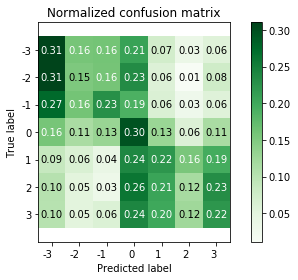

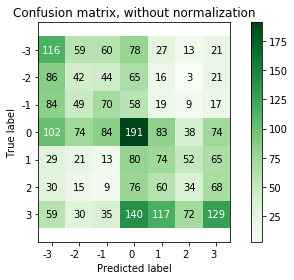

In [107]:
cmat.plot(y_test, y_pred_mlp, classes=list(y_columns.keys()), normalize=True)
cmat.plot(y_test, y_pred_mlp, classes=list(y_columns.keys()), normalize=False)

plt.show()

In [108]:
print(classification_report(y_test.argmax(axis=1), y_pred_mlp.argmax(axis=1), target_names = classes))

precision    recall  f1-score   support

          -3       0.23      0.31      0.26       374
          -2       0.14      0.15      0.15       277
          -1       0.22      0.23      0.23       306
           0       0.28      0.30      0.29       646
           1       0.19      0.22      0.20       334
           2       0.15      0.12      0.13       292
           3       0.33      0.22      0.26       582

    accuracy                           0.23      2811
   macro avg       0.22      0.22      0.22      2811
weighted avg       0.24      0.23      0.23      2811



In [109]:
model_conv1d = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 12, activation='relu', input_shape=data_shape),
    tf.keras.layers.Conv1D(64, 8, activation='relu'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_conv1d.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
model_conv1d.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_conv1d.evaluate(X_test, y_test, verbose=2)

Train on 6746 samples, validate on 1687 samples
Epoch 1/10
6746/6746 [==============================] - 9s 1ms/sample - loss: 1.9073 - accuracy: 0.2255 - val_loss: 1.8613 - val_accuracy: 0.2602
Epoch 2/10
6746/6746 [==============================] - 8s 1ms/sample - loss: 1.8385 - accuracy: 0.2428 - val_loss: 1.7385 - val_accuracy: 0.2733
Epoch 3/10
6746/6746 [==============================] - 10s 1ms/sample - loss: 1.7289 - accuracy: 0.2649 - val_loss: 1.6569 - val_accuracy: 0.3088
Epoch 4/10
6746/6746 [==============================] - 11s 2ms/sample - loss: 1.6886 - accuracy: 0.2859 - val_loss: 1.6570 - val_accuracy: 0.3124
Epoch 5/10
6746/6746 [==============================] - 11s 2ms/sample - loss: 1.6635 - accuracy: 0.3024 - val_loss: 1.6326 - val_accuracy: 0.3260
Epoch 6/10
6746/6746 [==============================] - 11s 2ms/sample - loss: 1.6439 - accuracy: 0.3024 - val_loss: 1.6607 - val_accuracy: 0.3189
Epoch 7/10
6746/6746 [==============================] - 10s 2ms/sample -

[1.5902125697168155, 0.3340448]

In [111]:
y_pred_conv1d = model_conv1d.predict(X_test) 

In [112]:
for i in range(y_pred_conv1d.shape[1]):
    print("Predicted goal difference " + str(list(y_columns.keys())[i]) + ":\t", 
            np.sum(y_pred_conv1d.argmax(axis=1) == i))

Predicted goal difference -3:	 35
Predicted goal difference -2:	 0
Predicted goal difference -1:	 450
Predicted goal difference 0:	 1290
Predicted goal difference 1:	 472
Predicted goal difference 2:	 0
Predicted goal difference 3:	 564


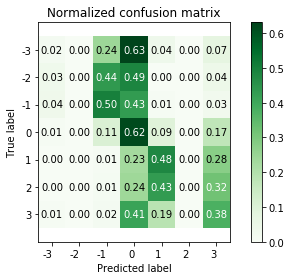

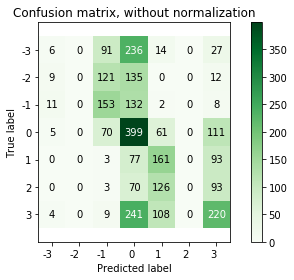

In [113]:
cmat.plot(y_test, y_pred_conv1d, classes=list(y_columns.keys()), normalize=True)
cmat.plot(y_test, y_pred_conv1d, classes=list(y_columns.keys()), normalize=False)

plt.show()

In [114]:
print(classification_report(y_test.argmax(axis=1), y_pred_conv1d.argmax(axis=1), target_names=classes))

precision    recall  f1-score   support

          -3       0.17      0.02      0.03       374
          -2       0.00      0.00      0.00       277
          -1       0.34      0.50      0.40       306
           0       0.31      0.62      0.41       646
           1       0.34      0.48      0.40       334
           2       0.00      0.00      0.00       292
           3       0.39      0.38      0.38       582

    accuracy                           0.33      2811
   macro avg       0.22      0.28      0.23      2811
weighted avg       0.25      0.33      0.27      2811

/home/daniel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


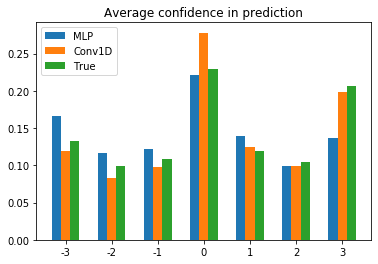

In [115]:
x = np.arange(len(classes)) 
width = 0.2

plt.bar(x - width, np.mean(y_pred_mlp, axis=0), width, label='MLP')
plt.bar(x, np.mean(y_pred_conv1d, axis=0), width, label='Conv1D')
plt.bar(x + width, np.mean(y_test, axis=0), width, label='True')

plt.legend(loc='upper left')
plt.xticks(x, classes)
plt.title("Average confidence in prediction")

plt.show()

In [116]:
mlp_prop = np.zeros(y.shape[1])
conv1d_prop = np.zeros(y.shape[1])

for i in range(y.shape[1]):
    mlp_prop[i] = np.sum(y_pred_mlp.argmax(axis=1) == i) / len(y_test)
    conv1d_prop[i] = np.sum(y_pred_conv1d.argmax(axis=1) == i) / len(y_test)

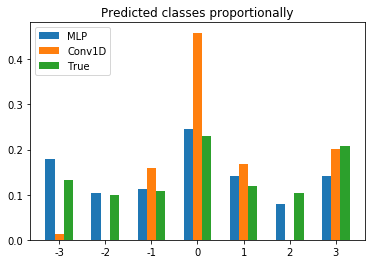

In [118]:
x = np.arange(len(classes)) 
width = 0.2

plt.bar(x - width, mlp_prop, width, label='MLP')
plt.bar(x, conv1d_prop, width, label='Conv1D')
plt.bar(x + width, np.mean(y_test, axis=0), width, label='True')

plt.title("Predicted classes proportionally")
plt.legend(loc='upper left')
plt.xticks(x, classes)

plt.show()

In [120]:
confidence_true_mlp = (y_pred_mlp * y_test).max(axis=1)
confidence_true_conv1d = (y_pred_conv1d * y_test).max(axis=1)

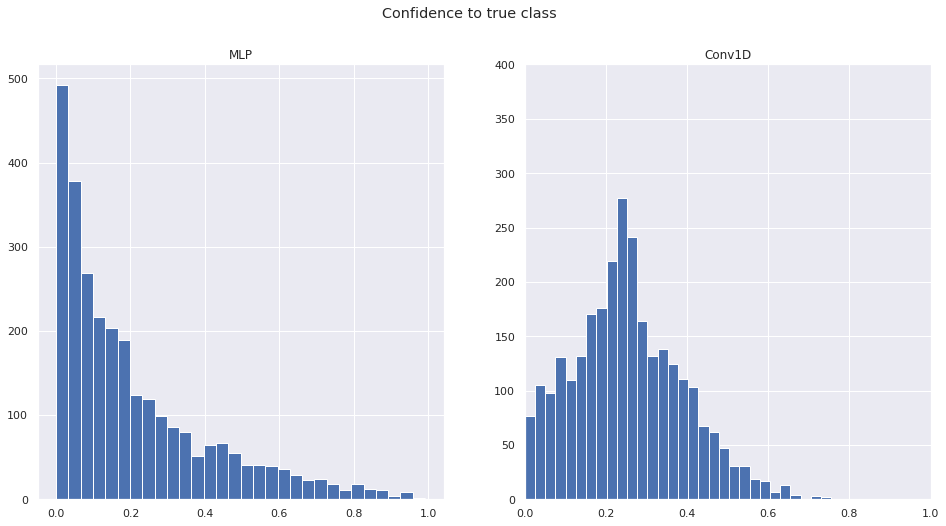

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

ax[0].hist(confidence_true_mlp, bins=30)
ax[1].hist(confidence_true_conv1d, bins=30)

ax[0].set_title("MLP")
ax[1].set_title("Conv1D")


plt.xlim((0,1))
plt.ylim((0, 400))
plt.suptitle("Confidence to true class")

plt.show()

In [143]:
extreme_results_mlp = id_test[np.argsort(confidence_true_mlp)[:10]]
extreme_results_conv1d = id_test[np.argsort(confidence_true_conv1d)[:10]]

In [132]:
game_stats = pd.read_csv("data/csv/game_teams_stats.csv")

In [134]:
home = game_stats.loc[game_stats['HoA']=='home']
away = game_stats.loc[game_stats['HoA']=='away']
games = home.merge(away, on='game_id', suffixes=['_home', '_away'])

In [146]:
games.columns

Index(['game_id', 'team_id_home', 'HoA_home', 'won_home', 'settled_in_home',
       'head_coach_home', 'goals_home', 'shots_home', 'hits_home', 'pim_home',
       'powerPlayOpportunities_home', 'powerPlayGoals_home',
       'faceOffWinPercentage_home', 'giveaways_home', 'takeaways_home',
       'team_id_away', 'HoA_away', 'won_away', 'settled_in_away',
       'head_coach_away', 'goals_away', 'shots_away', 'hits_away', 'pim_away',
       'powerPlayOpportunities_away', 'powerPlayGoals_away',
       'faceOffWinPercentage_away', 'giveaways_away', 'takeaways_away'],
      dtype='object')

In [147]:
relevant_columns = ['team_id_home', 'goals_home', 'shots_home', 'hits_home', 'pim_home',
       'powerPlayOpportunities_home', 'faceOffWinPercentage_home', 'giveaways_home', 'takeaways_home', 'team_id_away', 'goals_away', 'shots_away', 'hits_away', 'pim_away',
       'powerPlayOpportunities_away', 'giveaways_away', 'takeaways_away']

In [148]:
games.loc[games['game_id'].isin(extreme_results_mlp), relevant_columns]

,team_id_home,goals_home,shots_home,hits_home,pim_home,powerPlayOpportunities_home,faceOffWinPercentage_home,giveaways_home,takeaways_home,team_id_away,goals_away,shots_away,hits_away,pim_away,powerPlayOpportunities_away,giveaways_away,takeaways_away
2405,6,3,32,27,4,3,57.1,9,9,23,1,28,25,6,2,3,8
3234,29,3,39,24,4,2,51.6,5,6,2,3,28,18,4,2,1,3
4243,26,4,22,30,6,4,48.9,8,0,17,1,21,25,10,2,4,1
6284,8,3,23,26,4,2,45.2,14,9,6,2,43,23,4,2,8,7
7364,23,1,26,17,20,4,43.3,7,3,18,7,48,9,30,4,3,7
7540,6,5,29,25,7,0,45.9,6,10,5,1,42,20,5,1,15,11
9261,6,3,36,16,7,4,55.4,13,14,7,2,30,19,15,1,13,6
10335,26,2,26,34,11,2,45.3,12,9,18,5,28,29,9,3,7,4
10603,30,5,26,21,9,3,55.0,4,7,25,2,25,19,13,1,2,1
10973,18,1,30,26,6,3,58.1,5,9,19,1,15,20,6,3,5,7


In [149]:
games.loc[games['game_id'].isin(extreme_results_conv1d), relevant_columns]

,team_id_home,goals_home,shots_home,hits_home,pim_home,powerPlayOpportunities_home,faceOffWinPercentage_home,giveaways_home,takeaways_home,team_id_away,goals_away,shots_away,hits_away,pim_away,powerPlayOpportunities_away,giveaways_away,takeaways_away
175,8,2,27,23,8,7,56.5,13,5,6,1,32,11,27,4,3,5
1515,13,5,26,19,2,2,50.8,5,8,52,2,31,46,4,1,1,6
1570,29,2,27,21,2,3,53.2,7,10,23,1,35,20,6,1,4,3
2788,19,2,29,17,20,6,55.9,4,7,9,2,33,28,26,3,2,10
6068,19,2,37,28,2,4,43.3,3,9,25,2,24,15,8,1,2,5
6691,5,3,31,22,14,5,63.6,7,3,21,4,31,42,12,6,3,8
7758,53,4,30,17,18,3,45.3,10,3,23,1,28,22,18,3,13,7
8681,25,2,23,31,8,3,47.2,11,5,26,3,30,30,8,3,3,4
10034,9,5,34,21,15,6,46.8,12,4,13,1,24,19,17,5,9,5
10287,2,1,24,22,8,3,66.0,11,11,1,2,35,23,6,4,9,13


In [150]:
games['pdo_home'] = games['goals_home'] / games['shots_home'] + (games['shots_away']-games['goals_away']) / games['shots_away']

games['pdo_away'] = games['goals_away'] / games['shots_away'] + (games['shots_home']-games['goals_home']) / games['shots_home']

In [154]:
goal_diff_mlp = y_test.argmax(axis=1) - y_pred_mlp.argmax(axis=1)
goal_diff_conv1d = y_test.argmax(axis=1) - y_pred_conv1d.argmax(axis=1)

In [165]:
games = games.sort_values(by='game_id')

In [166]:
games_test = games[games['game_id'].isin(np.sort(id_test))]

In [167]:
games_test.head()

,game_id,team_id_home,HoA_home,won_home,settled_in_home,head_coach_home,goals_home,shots_home,hits_home,pim_home,...,shots_away,hits_away,pim_away,powerPlayOpportunities_away,powerPlayGoals_away,faceOffWinPercentage_away,giveaways_away,takeaways_away,pdo_home,pdo_away
9625,2010020003,30,home,False,REG,Todd Richards,3,29,19,10,...,31,14,10,5,2,38.8,11,3,0.974416,1.025584
9307,2010020015,2,home,False,SO,Scott Gordon,4,47,42,14,...,22,21,16,7,1,42.6,9,15,0.903288,1.096712
10332,2010020022,28,home,False,OT,Todd McLellan,2,35,11,8,...,25,30,16,4,1,48.1,3,11,0.937143,1.062857
8760,2010020024,27,home,False,REG,Dave Tippett,0,29,17,12,...,37,19,6,4,0,50.0,5,5,0.918919,1.081081
10013,2010020029,19,home,True,REG,Davis Payne,5,53,13,65,...,14,17,78,4,1,46.0,4,1,1.022911,0.977089


In [170]:
games_test['game_id'].all() == np.sort(id_test).all()

True

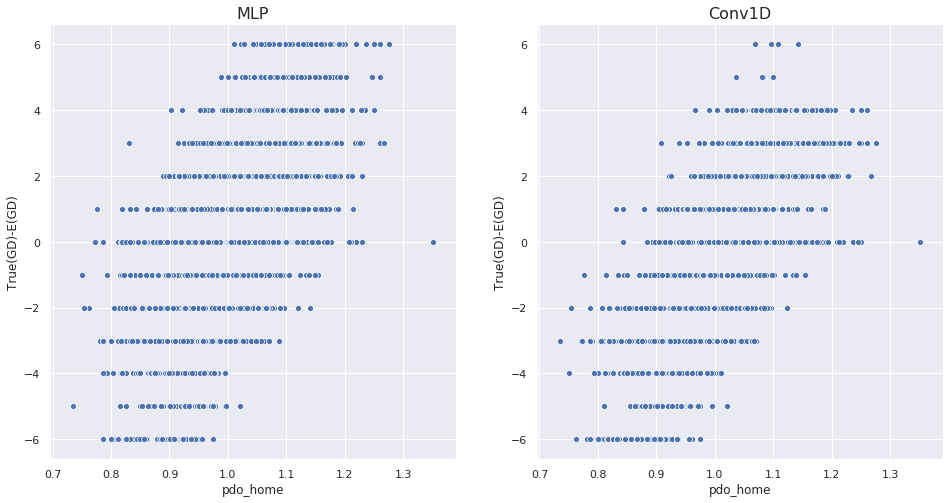

In [184]:
sns.set()

fig, ax = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(games_test['pdo_home'], goal_diff_mlp[np.argsort(id_test)], ax=ax[0])
sns.scatterplot(games_test['pdo_home'], goal_diff_conv1d[np.argsort(id_test)], ax=ax[1])

ax[0].set_title("MLP", fontsize=16)
ax[1].set_title("Conv1D", fontsize=16)

ax[0].set_ylabel("True(GD)-E(GD)")
ax[1].set_ylabel("True(GD)-E(GD)")

plt.show()

In [188]:
print(np.corrcoef(games_test['pdo_home'], goal_diff_mlp[np.argsort(id_test)])[0, 1])

0.6262052514384605


In [189]:
print(np.corrcoef(games_test['pdo_home'], goal_diff_conv1d[np.argsort(id_test)])[0, 1])

0.7329708910634826
